# NN Shape Analysis - VAD

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import re

from scipy import stats

plots = "D:/Research/Spyder/plots/"

save_images = True

In [2]:
dataset = "power"
activation = "CompTanh"

fig_size = (1.8,1.8) if "small" in dataset else (6,1.8)
legend_on = "small" not in dataset
showfliers = "small" not in dataset
midline_width =  2 - ("small" in dataset)
y_on = True

data = {}
for HL in [3,4]:
    for method in ["all", "allsoft"]:
        for computer in [1,2]:
            try:
                with open("SparsityTest_power{}_HL{}_{}_{}.json".format(activation, HL, method, computer), 'r') as nsa:
                    data.update(json.load(nsa))
            except: pass
            
activation = "CompTanh_gradual"

#with open("SparsityTest_power{}0.json".format(activation), 'r') as nsa:
#    data2 = json.load(nsa)
#    print(len(data))
#    data.update(data2)
with open("SparsityTest_power{}1.json".format(activation), 'r') as nsa:
    data2 = json.load(nsa)
    print(len(data2))
    data.update(data2)

with open("SparsityTest_power{}2.json".format(activation), 'r') as nsa:
    data2 = json.load(nsa)
    print(len(data2))
    data.update(data2)

        
acc_lim = [70, 85]
iqr_lim = [2, 15]

def str_to_list(in_string):
    temp = in_string[1:-1].split(',')
    return [int(s) for s in temp]

score_num = 0
data = {t:d for t,d in data.items() if type(d) is dict}
for t,d in data.items():
    
    d["shape"] = str_to_list(d["shape"])
    d["hidden"] = len(d["shape"]) - 2
    method_temp = t.split('_')[1:3]
    if len(method_temp[1]) < len(method_temp[0]):
        if "soft" in method_temp[0]:
            method_temp.append(method_temp[0][-1])
            method_temp[0] = "allsoft"
        else:
            method_temp[1] = '0' + method_temp[1]
    
    d["method"] = "_".join(method_temp)
    if "prune" in d["method"] and d["method"][-4] != '1': d["method"] = d["method"][:-3] + '0' + d["method"][-3:]
    #d["method"] = t.split(']')[1]
    #d["method"] = d["method"][:re.search(r"\d",d["method"]).start()]
    
    d["idealacc"] *= 100
    acc = d["accs"]
    scores = (list(acc.values()))
    scores = np.vstack([np.array(s) for s in scores])[score_num]
    d["medians"] = np.median(scores) * 100
    d["iqr"] = (np.quantile(scores, 0.75) - np.quantile(scores, 0.25)) * 100
    #for i in range(d["hidden"]):
    #    d["shrink"] = d.get("shrink", 1) * (d["shape"][i] / d["shape"][i + 1]) ** (d["hidden"] + 1 - i)
    #d['loc'], d['spread'] = stats.gumbel_r.fit(scores)
    d["u75"] = scores.max() - np.quantile(scores, 0.25)
    d["synapses"] = sum([n * d["shape"][i + 1] for i,n in enumerate(d["shape"][:-1])])
    #print(d)
    #input()

791
384


In [3]:
pd.DataFrame.from_dict(data,orient="index").groupby("method").hidden.value_counts()

method              hidden
all_010             3         50
                    4         50
all_020             3         50
                    4         50
allsoft_10_1        3         50
                    4         50
allsoft_10_2        3         50
                    4         50
allsoft_10_4        3         50
                    4         50
allsoft_10_8        3         50
                    4         50
allsoft_20_1        3         50
                    4         50
allsoft_20_2        3         50
                    4         50
allsoft_20_4        3         50
                    4         50
allsoft_20_8        3         50
                    4         50
once_0100           3         50
                    4         50
once_0200           3         50
                    4         50
once_0500           3         50
                    4         50
once_1000           3         50
                    4         50
prune_backward0400  4         52
                

In [54]:
y_label = {"idealacc": "Ideal\nAccuracies (%)",
           "medians": "Median\nAccuracies (%)",
           "iqr": "Inter-quartile\nRange (%)",
          "epochs": "Training Epochs"}

y_lim = {"idealacc": (60,100),
           "medians": (60,100),
           "iqr": (0,20),
          "epochs": (0,10000)}

sns.set_style("whitegrid", rc={'font.family':"Times New Roman", 'dpi': 300})

def plot_fig(df, y_name, filename, legend_labels=None, y_limits=None, x_on=True, save = False):
    

    if "once" in filename.lower() and y_name == "idealacc" and "small" not in dataset:
        fig = plt.figure(figsize=(fig_size[0]*0.6,fig_size[1]))
    else:
        fig = plt.figure(figsize=fig_size)

    plt0 = sns.boxenplot(x = "hidden", y = y_name, data = df, hue="method", palette=sns.color_palette("Paired"), linewidth=0.5, showfliers=showfliers)
    for c in plt0.axes.collections:
        c._sizes = np.array([12])
    for l in plt0.lines:
        l.set_linewidth(midline_width)
        l._aplha = 0.8
    
    if "once" not in filename.lower():
        if x_on:
            plt.xlabel("No. Hidden Layers", labelpad=0, fontsize=12)
        else:
            plt0.axes.xaxis.set_visible(False)
        if y_on:
            plt.ylabel(y_label[y_name], labelpad = 0, fontsize=12)
        else:
            plt0.axes.yaxis.set_visible(False)

        if legend_labels:
            if type(legend_labels) is list:
                L = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
                for i,l in enumerate(L.get_texts()):
                    l.set_text(legend_labels[i])
            else:
                plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                           ncol=3, mode="expand", borderaxespad=0.)
            
        else:
            L = plt.legend()
            L.set_visible(False)
    
    else:
        plt.xlabel("No. Hidden Layers", labelpad=0, fontsize=12)
        plt.ylabel(y_label[y_name], labelpad = 0, fontsize=12)
        if y_name == "idealacc":
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        else:
            L = plt.legend()
            L.set_visible(False)
            
        if y_limits is None:
            plt.ylim(y_lim[y_name])
        else:
            plt.ylim(y_limits)

    plt0.tick_params(axis='both', which='major', pad=0)
    fig = plt0.get_figure()
    figname = plots + filename + y_name + ".pdf"
    if save:
        fig.savefig(figname, dpi=300, bbox_inches='tight')

# Gradual Pruning

In [5]:
def rename_methods(method):
    if method.startswith("random"): return "random"
    method = method[6:]
    return method
    
data2 = {t:d for t,d in data.items() \
        if ("prune" in d["method"] or "random" in d["method"]) and d["hidden"] > 2}

In [6]:
df = pd.DataFrame.from_dict(data2, orient = "index")
df["method"] = df["method"].apply(rename_methods)
df.sort_values(["method"], axis = 0, inplace = True)
#print(df.head())
print(df["hidden"].value_counts())
if "computer" in df.columns:
    df.drop(["computer"], axis = 1, inplace = True)
    df.dropna(how = "all", inplace = True)
#df.head()

4    520
3    475
Name: hidden, dtype: int64


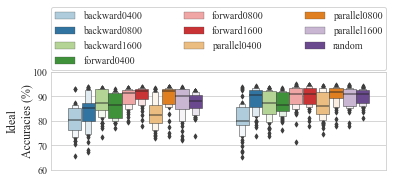

In [7]:
file_header = dataset + "_sparseGradual_"
plot_fig(df, "idealacc", file_header, legend_labels = legend_on, x_on=False, save = save_images)


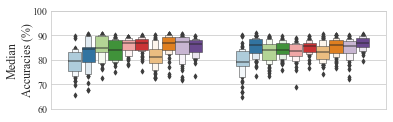

In [8]:
plot_fig(df, "medians", file_header, legend_labels = False, x_on=False, save = save_images)


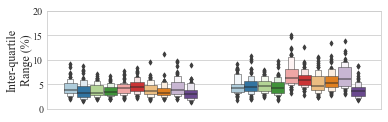

In [9]:
plot_fig(df, "iqr", file_header, legend_labels = False, x_on=False, save = save_images)

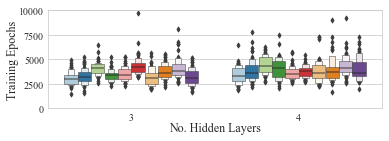

In [10]:
plot_fig(df, "epochs", file_header, legend_labels = False, x_on=True, save = save_images)

# Repeated Full Pruning

In [11]:
data2 = {t:d for t,d in data.items() if (d["method"].startswith("all") or "random" in d["method"])}

df = pd.DataFrame.from_dict(data2, orient = "index")
df.loc[df["method"].str.startswith("random"),"method"] = "random"
df.sort_values(["method"], axis = 0, inplace = True)
#print(df.head())
print(df["hidden"].value_counts())
if "computer" in df.columns:
    df.drop(["computer"], axis = 1, inplace = True)
    df.dropna(how = "all", inplace = True)
#df.head()

4    550
3    550
Name: hidden, dtype: int64


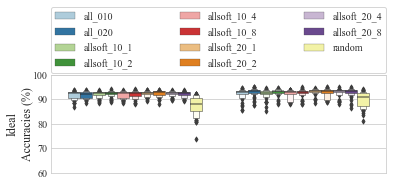

In [12]:
file_header = dataset + "_sparseAll_"

plot_fig(df, "idealacc", file_header, legend_labels = legend_on, x_on=False, save = save_images)

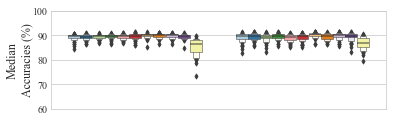

In [13]:
plot_fig(df, "medians", file_header, legend_labels = False, x_on=False, save = save_images)

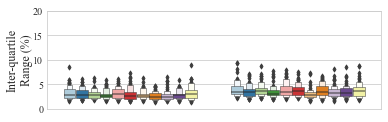

In [14]:
plot_fig(df, "iqr", file_header, legend_labels = False, x_on=False, save = save_images)

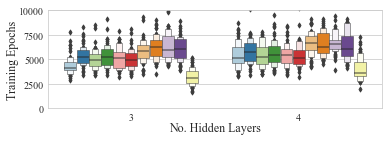

In [15]:
plot_fig(df, "epochs", file_header, legend_labels = False, x_on=True, save = save_images)

# Prune Once

In [55]:
fig_size = (1.8,1.8) if "small" in dataset else (2.9,1.8)

In [56]:
def rename_methods(method):
    if method.startswith("random"): return "rand."
    method = "{}".format(int(method[-4:]))
    return method
    
data2 = {t:d for t,d in data.items() \
        if ("once" in d["method"] or "random" in d["method"]) and d["hidden"] > 2}

In [57]:
df = pd.DataFrame.from_dict(data2, orient = "index")
df.sort_values(["method"], axis = 0, inplace = True)
df["method"] = df["method"].apply(rename_methods)
#print(df.head())
print(df["hidden"].value_counts())
if "computer" in df.columns:
    df.drop(["computer"], axis = 1, inplace = True)
    df.dropna(how = "all", inplace = True)
#df.head()

4    250
3    250
Name: hidden, dtype: int64


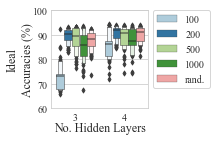

In [58]:
file_header = dataset + "_sparseOnce_"
plot_fig(df, "idealacc", file_header, legend_labels = legend_on, x_on=False, save = save_images)


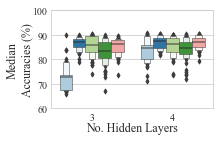

In [59]:
plot_fig(df, "medians", file_header, legend_labels = False, x_on=False, save = save_images)

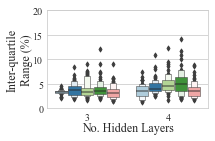

In [60]:
plot_fig(df, "iqr", file_header, legend_labels = False, x_on=False, save = save_images)

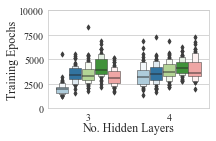

In [61]:
plot_fig(df, "epochs", file_header, legend_labels = False, x_on=True, save = save_images)